In [16]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm, tnrange as trange
%matplotlib inline

# Replicate "right panel" experiment from appendix with 4 losses

In [17]:
def simult(x):
    return np.array([x[1:].sum(), x[2:].sum() - x[0], x[-1] - x[:2].sum(), -x[:-1].sum()])

In [18]:
def half_norm_grad(x):
    return np.array([3*x[0] + 2*x[1] - 2*x[3],
                     2*x[0] + 3*x[1] + 2*x[2],
                     2*x[1] + 3*x[2] + 2*x[3],
                     (-2)*x[0] + 2*x[2] + 3*x[3]])

In [19]:
def get_losses(x):
    return np.array([x[0]*x[1:].sum(),
                     x[1] * (x[2:].sum() - x[0]),
                     x[2] * (x[3] - x[:2].sum()),
                     x[3] * (-x[:-1].sum())])

In [20]:
antisymm = np.array([[0, 1, 1, 1],
                     [-1, 0, 1, 1],
                     [-1, -1, 0, 1],
                     [-1, -1, -1, 0]])

In [21]:
def has_converged(losses):
    last_losses = np.array(losses[-10:])
    for i in range(x.shape[0]):
        cur_mean = last_losses[:, i].mean()
        if cur_mean > 0.1:
            return False
    return True

# Simult grad descent

In [22]:
x = np.random.normal(size=4)
print(x)

[ 0.97430948  0.7808839   0.9606976   0.87406942]


In [23]:
iters = 10000
lr = 0.01
diffs = []
for it in range(iters):
    x_new = x - lr * simult(x)
    diff = np.linalg.norm(x_new - x)
    diffs.append(diff)
    x = x_new

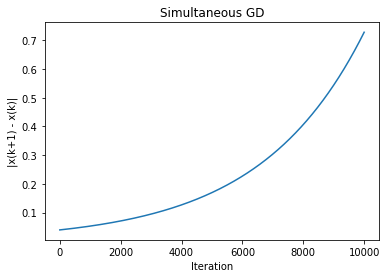

In [25]:
plt.xlabel('Iteration')
plt.ylabel('|x(k+1) - x(k)|')
plt.title('Simultaneous GD')
plt.plot(diffs)

Diverges!

# SGA with convergence criterion

In [26]:
x = np.random.normal(size=4)
print(x)

[ 0.71937419 -0.54173331  0.83360238 -1.541825  ]


In [27]:
iters = 10000
lr = 0.0001
diffs = []
losses = []
for it in range(iters):
    grad_new = (np.eye(antisymm.shape[0]) + antisymm.T) @ simult(x)
    x_new = x - lr * grad_new
    diff = np.linalg.norm(x_new - x)
    diffs.append(diff)
    losses.append(get_losses(x))
    x = x_new
    if has_converged(losses):
        print(f'Converged early at iteration {it+1}')
        break

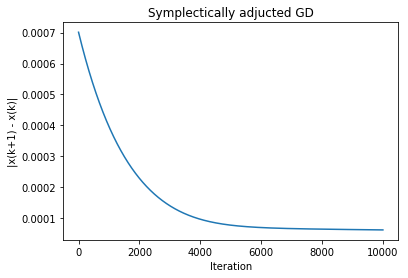

In [28]:
plt.xlabel('Iteration')
plt.ylabel('|x(k+1) - x(k)|')
plt.title('Symplectically adjucted GD')
plt.plot(diffs)

# Now with alignment

grad = grad of 1/2 norm of simult wrt player params

lam = 1/d (simult, grad) (A^T simult, grad) + eps, d=4, eps=0.1

In [151]:
x = np.random.normal(size=4)
print(x)

[ 0.33162797 -1.58073957 -1.51677535 -1.22340763]


In [152]:
iters = 10000
lr = 0.0001
eps = 0.1
diffs = []
for it in range(iters):
    lam_expr = (simult(x) @ half_norm_grad(x)) * ((antisymm.T @ simult(x)) @ half_norm_grad(x)) / x.shape[0] + eps
    lam = 1 if lam_expr >= 0 else -1
    grad_new = (np.eye(antisymm.shape[0]) + lam * antisymm.T) @ simult(x)
    x_new = x - lr * grad_new
    diff = np.linalg.norm(x_new - x)
    diffs.append(diff)
    x = x_new

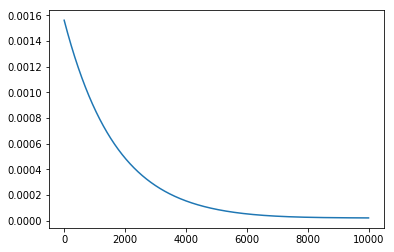

In [153]:
plt.plot(diffs)

Here lam_expr is almost exactly equal to eps and so the behavior is the same

# Dependency of time to convergence on lr

In [14]:
results = []
lrs = []
for lr in tqdm(np.arange(0.005, 0.25, 0.005)):
    cur_results = []
    for i in range(50):
        x = np.random.normal(size=4)
        iters = 100000  # maximum number of iterations
        losses = []
        for it in range(iters):
            grad_new = (np.eye(antisymm.shape[0]) + antisymm.T) @ simult(x)
            x_new = x - lr * grad_new
            losses.append(get_losses(x))
            x = x_new
            if has_converged(losses):
                break
        cur_results.append(it+1)
    cur_results = np.array(cur_results)
#     results.append([cur_results.mean(), cur_results.std()])
    results.append(cur_results.mean())
    lrs.append(lr)

Text(0,0.5,'Number of iterations')

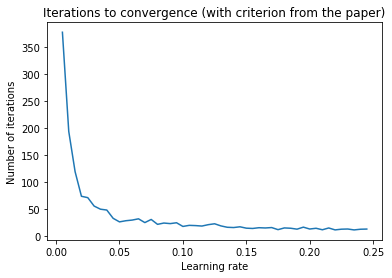

In [15]:
plt.plot(lrs, results)
plt.title('Iterations to convergence (with criterion from the paper)')
plt.xlabel('Learning rate')
plt.ylabel('Number of iterations')